<a href="https://colab.research.google.com/github/Jeetesh1512/learnML/blob/main/Triple_attention_Cifar10_efficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers,layers,models
from keras import Sequential, Model, backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input , Flatten, Conv2D, UpSampling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0

In [3]:
cifar10 = tf.keras.datasets.cifar10
(x_train,Y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


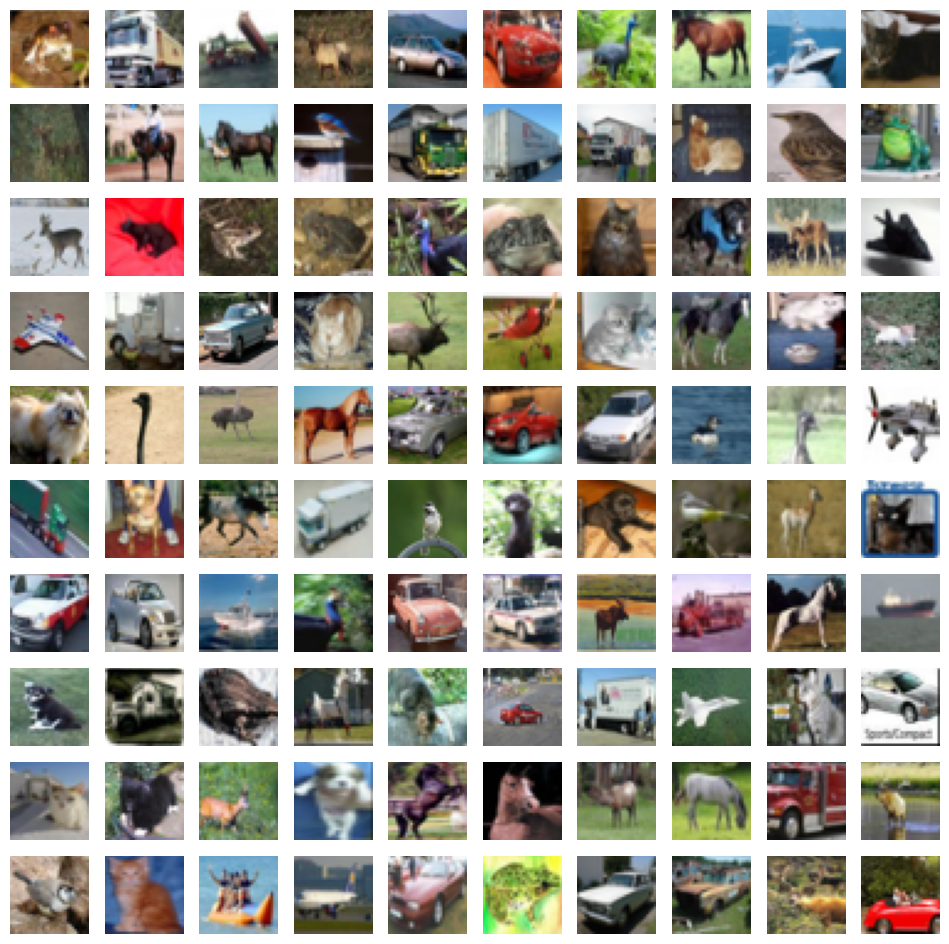

In [4]:
plt.figure(figsize=(12,12))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(x_train[i],cmap='gray')

In [5]:
X_train,X_val,y_train,y_val = train_test_split(x_train,Y_train,test_size=0.2)

In [6]:
y_train = to_categorical(y_train, num_classes = 10)
y_val = to_categorical(y_val, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [7]:
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

In [8]:
print(x_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 10) (10000, 10) (10000, 10)


In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range = 0.1,
    shear_range=0.1,
    horizontal_flip = True,
    vertical_flip=False
)
train_datagen.fit(X_train)

In [10]:
from tensorflow.keras import layers

class SimilarityLossLayer(layers.Layer):
    def __init__(self, lambda_sim=0.1, **kwargs):
        super().__init__(**kwargs)
        self.lambda_sim = lambda_sim

    def call(self, f1, f2):
        # Compute cosine similarity
        f1_norm = tf.nn.l2_normalize(f1, axis=-1)
        f2_norm = tf.nn.l2_normalize(f2, axis=-1)
        sim_loss = tf.reduce_mean(tf.square(f1_norm - f2_norm))
        self.add_loss(self.lambda_sim * sim_loss)
        return f1, f2  # Return unchanged features for next layers

In [11]:
def triple_attention(f1, f2):
    # Channel Attention
    def channel_attention(x):
        avg_pool = layers.GlobalAveragePooling2D()(x)
        dense1 = layers.Dense(x.shape[-1] // 8, activation='relu')(avg_pool)
        dense2 = layers.Dense(x.shape[-1], activation='sigmoid')(dense1)
        scale = layers.Reshape((1, 1, x.shape[-1]))(dense2)
        return layers.Multiply()([x, scale])

    # Spatial Attention (fixed: use keras ops, not tf ops)
    def spatial_attention(x):
        avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
        max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
        concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
        attn = layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
        return layers.Multiply()([x, attn])

    # Cross Attention
    def cross_attention(a, b):
        q = layers.Conv2D(a.shape[-1], 1, padding="same")(a)
        k = layers.Conv2D(b.shape[-1], 1, padding="same")(b)
        v = layers.Conv2D(b.shape[-1], 1, padding="same")(b)
        attn = layers.Activation('softmax')(layers.Multiply()([q, k]))
        return layers.Add()([a, layers.Multiply()([attn, v])])

    ca = channel_attention(f1)
    sa = spatial_attention(f1)
    xa = cross_attention(f1, f2)

    out = layers.Add()([ca, sa, xa])
    return out

In [12]:
def build_dual_branch_model(input_shape=(32, 32, 3), num_classes=10, lambda_sim=0.1):
    inputs = layers.Input(shape=input_shape)
    x = layers.UpSampling2D(size=(7, 7))(inputs)  # 32x32 → 224x224

    # --- Branch 1 ---
    base1_input = layers.Input(shape=(224, 224, 3))
    base1 = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=base1_input)
    branch1_model = models.Model(base1_input, base1.output, name="EffNetB0_Branch1")
    f1_map = branch1_model(x)
    f1 = layers.GlobalAveragePooling2D()(f1_map)

    # --- Branch 2 ---
    base2_input = layers.Input(shape=(224, 224, 3))
    base2 = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=base2_input)
    branch2_model = models.Model(base2_input, base2.output, name="EffNetB0_Branch2")
    f2_map = branch2_model(x)
    f2 = layers.GlobalAveragePooling2D()(f2_map)


    # --- Make only BatchNorm layers trainable ---
    for layer in branch1_model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

    for layer in branch2_model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False


    # --- Triple Attention ---
    ta1 = triple_attention(f1_map, f2_map)
    ta2 = triple_attention(f2_map, f1_map)

    fused = layers.Concatenate()([
        layers.GlobalAveragePooling2D()(ta1),
        layers.GlobalAveragePooling2D()(ta2)
    ])


    # --- Classification Head ---
    fused = layers.Dense(256, activation='relu')(fused)
    fused = layers.Dropout(0.3)(fused)
    outputs = layers.Dense(num_classes, activation='softmax')(fused)

    # --- Custom Loss ---
    f1, f2 = SimilarityLossLayer(lambda_sim)(f1, f2)

    model = models.Model(inputs, outputs,name='DualBranch_with_tripleattention')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [13]:
model = build_dual_branch_model()
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "DualBranch_with_tripleattention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (UpSampling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EffNetB0_Branch1    │ (None, 7, 7,      │  4,049,571 │ up_sampling2d[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EffNetB0_Branch2    │ (None, 7, 7,      │  4,049,571 │ up_sampling2d[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ EffNetB0_Branch1… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7,      │  1,639,680 │ EffNetB0_Branch1… │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7,      │  1,639,680 │ EffNetB0_Branch2… │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ EffNetB0_Branch2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7,      │  1,639,680 │ EffNetB0_Branch2… │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 7, 7,      │  1,639,680 │ EffNetB0_Branch1… │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 160)       │    204,960 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 7, 7, 1)   │          0 │ EffNetB0_Branch1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 7, 7, 1)   │          0 │ EffNetB0_Branch1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 7, 7,      │          0 │ conv2d_1[0][0],   │
│ (Multiply)          │ 1280)             │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 160)       │    204,960 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 7, 7, 1)   │          0 │ EffNetB0_Branch2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 7, 7, 1)   │          0 │ EffNetB0_Branch2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 7, 7,      │          0 │ conv2d_5[0][0],   │
│ (Multiply)          │ 1280)             │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1280)      │    206,080 │ dense[0][0]     

 Total params: 19,417,686 (74.07 MB)

 Trainable params: 11,402,576 (43.50 MB)

 Non-trainable params: 8,015,110 (30.58 MB)

#Just to visualize

In [14]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# # --- Simple Cross-Attention Block ---
# def cross_attention(x1, x2):
#     attn = layers.Attention()([x1, x2])
#     return layers.Add()([x1, attn])

# # --- Simple Similarity Loss ---
# def similarity_loss(f1, f2):
#     return tf.reduce_mean(tf.square(f1 - f2))

# # --- Mini placeholder branch (instead of EfficientNet) ---
# def small_placeholder_model(name="MiniBranch"):
#     inp = layers.Input((224, 224, 3), name=f"{name}_input")
#     x = layers.Conv2D(16, 3, activation='relu', padding='same', name=f"{name}_conv1")(inp)
#     x = layers.MaxPooling2D(name=f"{name}_pool1")(x)
#     x = layers.Conv2D(32, 3, activation='relu', padding='same', name=f"{name}_conv2")(x)
#     x = layers.MaxPooling2D(name=f"{name}_pool2")(x)
#     return models.Model(inp, x, name=name)

# # --- Dual-Branch Model (visualization-friendly) ---
# def build_dual_branch_model(input_shape=(32, 32, 3), num_classes=10, lambda_sim=0.1):
#     inputs = layers.Input(shape=input_shape, name="Input_Image")
#     x = layers.UpSampling2D(size=(7, 7), name="Upsample_32_to_224")(inputs)  # 32x32 → 224x224

#     # --- Branch 1 ---
#     branch1 = small_placeholder_model("Branch1")
#     f1_map = branch1(x)
#     f1 = layers.GlobalAveragePooling2D(name="Branch1_GlobalAvgPool")(f1_map)

#     # --- Branch 2 ---
#     branch2 = small_placeholder_model("Branch2")
#     f2_map = branch2(x)
#     f2 = layers.GlobalAveragePooling2D(name="Branch2_GlobalAvgPool")(f2_map)

#     # --- Cross Attention ---
#     ca1 = cross_attention(f1_map, f2_map)
#     ca2 = cross_attention(f2_map, f1_map)
#     fused = layers.Concatenate(name="Concatenated_Attention")([
#         layers.GlobalAveragePooling2D()(ca1),
#         layers.GlobalAveragePooling2D()(ca2)
#     ])

#     # --- Classification Head ---
#     fused = layers.Dense(256, activation='relu', name="Dense_256")(fused)
#     fused = layers.Dropout(0.3, name="Dropout")(fused)
#     outputs = layers.Dense(num_classes, activation='softmax', name="Classifier")(fused)

#     model = models.Model(inputs, outputs, name="DualBranch_Visualization")

#     # --- Custom Loss ---
#     def custom_loss(y_true, y_pred):
#         base_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
#         sim_loss = similarity_loss(f1, f2)
#         return base_loss + lambda_sim * sim_loss

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#         loss=custom_loss,
#         metrics=['accuracy']
#     )

#     return model
# import tensorflow as tf
# from tensorflow.keras import layers, models

# # --- Simple Cross-Attention Block ---
# def cross_attention(x1, x2):
#     attn = layers.Attention()([x1, x2])
#     return layers.Add()([x1, attn])

# # --- Simple Similarity Loss ---
# def similarity_loss(f1, f2):
#     return tf.reduce_mean(tf.square(f1 - f2))

# # --- Mini placeholder branch (instead of EfficientNet) ---
# def small_placeholder_model(name="MiniBranch"):
#     inp = layers.Input((224, 224, 3), name=f"{name}_input")
#     x = layers.Conv2D(16, 3, activation='relu', padding='same', name=f"{name}_conv1")(inp)
#     x = layers.MaxPooling2D(name=f"{name}_pool1")(x)
#     x = layers.Conv2D(32, 3, activation='relu', padding='same', name=f"{name}_conv2")(x)
#     x = layers.MaxPooling2D(name=f"{name}_pool2")(x)
#     return models.Model(inp, x, name=name)

# # --- Dual-Branch Model (visualization-friendly) ---
# def build_dual_branch_model(input_shape=(32, 32, 3), num_classes=10, lambda_sim=0.1):
#     inputs = layers.Input(shape=input_shape, name="Input_Image")
#     x = layers.UpSampling2D(size=(7, 7), name="Upsample_32_to_224")(inputs)  # 32x32 → 224x224

#     # --- Branch 1 ---
#     branch1 = small_placeholder_model("Branch1")
#     f1_map = branch1(x)
#     f1 = layers.GlobalAveragePooling2D(name="Branch1_GlobalAvgPool")(f1_map)

#     # --- Branch 2 ---
#     branch2 = small_placeholder_model("Branch2")
#     f2_map = branch2(x)
#     f2 = layers.GlobalAveragePooling2D(name="Branch2_GlobalAvgPool")(f2_map)

#     # --- Cross Attention ---
#     ca1 = cross_attention(f1_map, f2_map)
#     ca2 = cross_attention(f2_map, f1_map)
#     fused = layers.Concatenate(name="Concatenated_Attention")([
#         layers.GlobalAveragePooling2D()(ca1),
#         layers.GlobalAveragePooling2D()(ca2)
#     ])

#     # --- Classification Head ---
#     fused = layers.Dense(256, activation='relu', name="Dense_256")(fused)
#     fused = layers.Dropout(0.3, name="Dropout")(fused)
#     outputs = layers.Dense(num_classes, activation='softmax', name="Classifier")(fused)

#     model = models.Model(inputs, outputs, name="DualBranch_Visualization")

#     # --- Custom Loss ---
#     def custom_loss(y_true, y_pred):
#         base_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
#         sim_loss = similarity_loss(f1, f2)
#         return base_loss + lambda_sim * sim_loss

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#         loss=custom_loss,
#         metrics=['accuracy']
#     )

#     return model

# from tensorflow.keras.utils import plot_model

# sample = build_dual_branch_model()
# plot_model(
#     sample,
#     to_file="dual_branch_visual.png",
#     show_shapes=True,
#     show_layer_names=True,
#     expand_nested=True,
#     dpi=100
# )


In [15]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.6,
    min_lr=1e-6)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)


checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/saved_models/TripleAttention/dual_effnet_epoch{epoch:02d}_valAcc{val_accuracy:.4f}.weights.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [16]:
model.load_weights('/content/drive/MyDrive/dual_effnet_epoch01_valAcc0.9775.weights.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 450 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
history = model.fit(
    train_datagen.flow(X_train,y_train,batch_size=16),
    validation_data = (X_val,y_val),
    epochs=40,
    verbose=1,
    callbacks=[checkpoint]
)

Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9321 - loss: 0.2147
Epoch 1: val_accuracy improved from -inf to 0.97640, saving model to /content/drive/MyDrive/saved_models/TripleAttention/dual_effnet_epoch01_valAcc0.9764.weights.h5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 446s 135ms/step - accuracy: 0.9321 - loss: 0.2147 - val_accuracy: 0.9764 - val_loss: 0.0702
Epoch 2/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9369 - loss: 0.2014
Epoch 2: val_accuracy improved from 0.97640 to 0.98190, saving model to /content/drive/MyDrive/saved_models/TripleAttention/dual_effnet_epoch02_valAcc0.9819.weights.h5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 310s 124ms/step - accuracy: 0.9369 - loss: 0.2014 - val_accuracy: 0.9819 - val_loss: 0.0595
Epoch 3/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9356 - loss: 0.1981
Epoch 3: val_accuracy did not improve from 0.98190
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 308s 123ms/step - accuracy: 0.9356 - loss: 0.1981 - val_accuracy: 0.9760 - val_l

In [18]:
results = model.evaluate(X_test,y_test,verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.9548 - loss: 0.2355


In [19]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.9548 - loss: 0.2355
Test Loss: 0.2259
Test Accuracy: 95.48%


In [20]:
def plot_history(history):
    val_loss = history.history['val_loss' ]
    loss =     history.history['loss' ]
    acc =      history.history['accuracy' ]
    val_acc =  history.history['val_accuracy' ]

    epochs    = range(1,len(acc)+1,1)

    plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
    plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

    plt.plot  ( epochs,     loss, 'r--', label='Training loss' )
    plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
    plt.title ('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

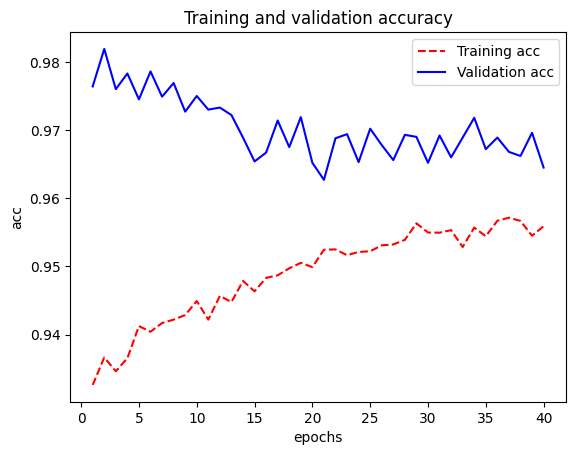

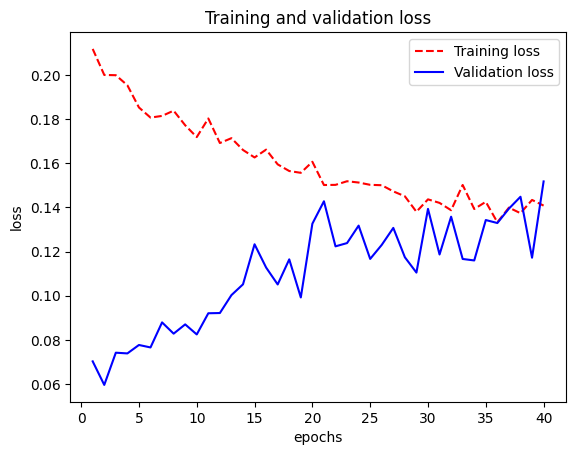

<Figure size 640x480 with 0 Axes>

In [21]:
plot_history(history)

313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step


<Figure size 1200x1200 with 0 Axes>

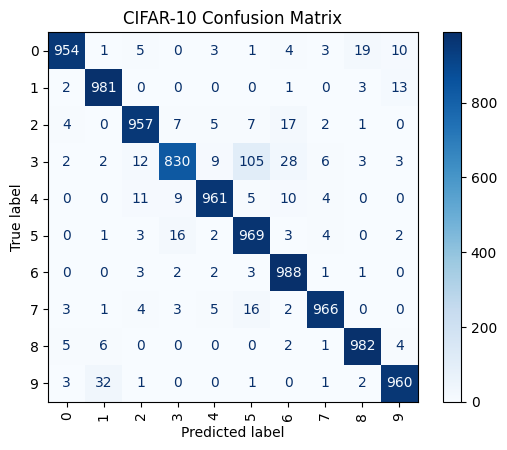

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------------------
# 1. Predict labels for test set
# -------------------------------
y_pred_probs = model.predict(X_test)          # probabilities
y_pred = np.argmax(y_pred_probs, axis=1)      # predicted class indices
y_true = np.argmax(y_test, axis=1)            # true class indices

# -------------------------------
# 2. Compute confusion matrix
# -------------------------------
cm = confusion_matrix(y_true, y_pred)

# -------------------------------
# 3. Display confusion matrix
# -------------------------------
plt.figure(figsize=(12,12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("CIFAR-10 Confusion Matrix")
plt.show()
